In [1]:
import _pickle as pickle
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os
import seaborn as sns
import pandas as pd
import timeit

from itertools import product

from utils import set_size, pgf_with_latex

In [2]:
plt.style.use("seaborn-v0_8-colorblind")

# Using the set_size function as defined earlier
doc_width_pt = 452.9679

In [3]:
stats_keys = [
    "accuracy",
    "p_iwl",
    "context contains query class",
    "loss",
    "ic_pred",
    "iw_pred",
]

In [4]:
repo_path = "/Users/chanb/research/ualberta/icl/simple_icl"
results_dir = "/Users/chanb/research/ualberta/icl/cc_results/paper_experiments/evaluation_results"

# repo_path = "/home/bryanpu1/projects/icl/simple_icl"
# results_dir = "/home/bryanpu1/projects/icl/scratch/evaluation_results"
# results_dir = "/home/bryanpu1/projects/icl/cc_results/evaluation_results"

if repo_path.startswith("/Users"):
    plt.rcParams.update(pgf_with_latex)

In [5]:
# variant_name = "synthetic-transformer-noisy_inputs"
variant_name = "omniglot-input_noise"

if variant_name.startswith("synthetic"):
    dataset_scale = np.log2
    checkpoint_steps = 500
    dataset_unit = "(in $\\log_{2}$)"
    num_seeds = 5
    chance_error = 9/10
else:
    dataset_scale = np.log10
    checkpoint_steps = 1000
    dataset_unit = "(in $\\log_{10}$)"
    num_seeds = 3
    chance_error = 1622/1623

stats_file = os.path.join(repo_path, "plot_utils/plots/agg_stats", "{}.feather".format(variant_name))
stats = pd.read_feather(stats_file)

os.makedirs(
    os.path.join(repo_path, "plot_utils/plots/acc-plots", variant_name),
    exist_ok=True
)

results_dir = os.path.join(results_dir, variant_name)
plot_names = [
    "pretraining",
    "context-default",
    "iwl",
    "iwl-flip_label",
    "icl-last_context",
    "icl-last_context-flip_label",
    "icl-except_first_context",
    "icl-except_first_context-flip_label",
]
plot_titles = [
    "Pretraining",
    "Context Default"
    "In-weight Evaluation",
    "In-weight Evaluation with Flipped Label",
    "In-context Evaluation with Last Context",
    "In-context Evaluation with Last Context + Flipped Label",
    "In-context Evaluation with Contexts but First",
    "In-context Evaluation with Contexts but First + Flipped Label",
]

map_stats_key = {
    "p_iwl": "$\\alpha(x)$",
    "accuracy": "Accuracy",
    "context contains query class": "Context Contains Query Class",
    "loss": "Loss",
    "ic_pred": "In-context Accuracy",
    "iw_pred": "In-weight Accuracy"
}

map_variant = {
    "ground_truth_prob": "$P(g(x) = c)$",
    "high_prob": "$P(high\_freq.)$"
}

In [6]:
variants = stats["variant"].unique()

In [7]:
stats["eval_name"].unique()

array(['eval-default-none-flip_label',
       'eval-default-high_prob-flip_label',
       'eval-default-low_prob-flip_label',
       'eval-relevant_context-none-flip_label',
       'eval-relevant_context-high_prob-flip_label',
       'eval-relevant_context-low_prob-flip_label',
       'eval-irrelevant_context-none-flip_label',
       'eval-irrelevant_context-high_prob-flip_label',
       'eval-irrelevant_context-low_prob-flip_label', 'eval-default-none',
       'eval-default-high_prob', 'eval-default-low_prob',
       'eval-relevant_context-none', 'eval-relevant_context-high_prob',
       'eval-relevant_context-low_prob', 'eval-irrelevant_context-none',
       'eval-irrelevant_context-high_prob',
       'eval-irrelevant_context-low_prob', 'pretraining'], dtype=object)

# Transformer

In [8]:
stats

,model_type,dirname,variant,seed,eval_name,stats_key,stats,dataset_size,p_relevant_context,input_noise_std
0,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,eval-default-none-flip_label,accuracy,"[0.0, 0.0, 0.0, 0.009, 0.036, 0.063, 0.084, 0....",1000000,0.9,0.0
1,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,eval-default-none-flip_label,context contains query class,"[0.892, 0.892, 0.892, 0.892, 0.892, 0.892, 0.8...",1000000,0.9,0.0
2,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,eval-default-none-flip_label,loss,"[7.857308387756348, 8.400153160095215, 9.46984...",1000000,0.9,0.0
3,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,eval-default-high_prob-flip_label,accuracy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000,0.9,0.0
4,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_0,eval-default-high_prob-flip_label,context contains query class,"[0.911, 0.911, 0.911, 0.911, 0.911, 0.911, 0.9...",1000000,0.9,0.0
...,...,...,...,...,...,...,...,...,...,...
4612,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,eval-irrelevant_context-low_prob,context contains query class,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000000,0.9,1.0
4613,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,eval-irrelevant_context-low_prob,loss,"[7.900698661804199, 8.157305717468262, 7.15407...",1000000,0.9,1.0
4614,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,pretraining,accuracy,"[0.0001, 0.897, 0.9059, 0.9481, 0.9801, 0.9871...",1000000,0.9,1.0
4615,transformer,omniglot-input_noise,dataset_size_1000000-p_relevant_context_0.9-in...,seed_1,pretraining,context contains query class,"[0.8986, 0.8986, 0.8986, 0.8986, 0.8986, 0.898...",1000000,0.9,1.0


In [9]:
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
input_noise_stds = sorted([float(input_noise_std) for input_noise_std in stats["input_noise_std"].unique()])
model_types = ["iw", "ic", "transformer"]

# Pretraining

### Loss

In [10]:
best_idxes = dict()

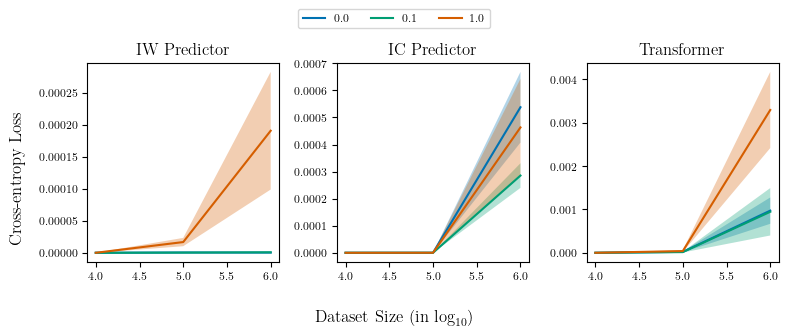

In [11]:
map_label = {
    "iw": "IW Predictor",
    "ic": "IC Predictor",
    "transformer": "Transformer",
}

p_relevant_context = 0.9

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for ax_i, model_type in enumerate(model_types):
    ax = axes[ax_i]
    for variant_i, input_noise_std in enumerate(input_noise_stds):
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "loss")
                & (stats["eval_name"] == "pretraining")
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = data.shape[1] - np.argmin(data[:, ::-1], axis=-1) - 1

            best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )] = best_idx

            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)

            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if ax_i == 0 else "")
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_title(map_label[model_type])
    # ax.set_ylim(0.0, 0.009)

fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size {}".format(dataset_unit))
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

### Accuracy

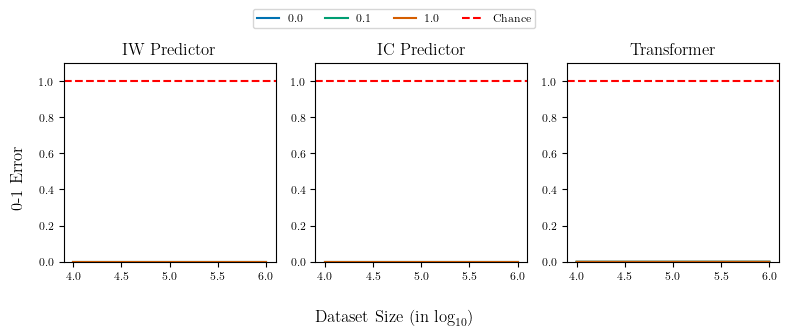

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for ax_i, model_type in enumerate(model_types):
    ax = axes[ax_i]
    for variant_i, input_noise_std in enumerate(input_noise_stds):
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = 1 - (np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["input_noise_std"] == f"{input_noise_std}")
                & (stats["stats_key"] == "accuracy")
                & (stats["eval_name"] == "pretraining")
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["model_type"] == f"{model_type}")
            ]["stats"].to_list()))
            best_idx = best_idxes[(
                model_type, p_relevant_context, input_noise_std, dataset_size
            )]
            sample = data[np.arange(num_seeds), best_idx]
            curr_mean = np.mean(sample)
            curr_std = np.std(sample)
            
            losses_mean.append(curr_mean)
            losses_std.append(curr_std)

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(num_seeds)

        ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=input_noise_std if ax_i == 0 else "")
        ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_title(map_label[model_type])
    ax.set_ylim(0.0, 1.1)
    ax.axhline(chance_error, label="Chance" if ax_i == 0 else "", c="red", linestyle="--")

fig.supylabel("0-1 Error")
fig.supxlabel("Dataset Size {}".format(dataset_unit))
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

## General Plots

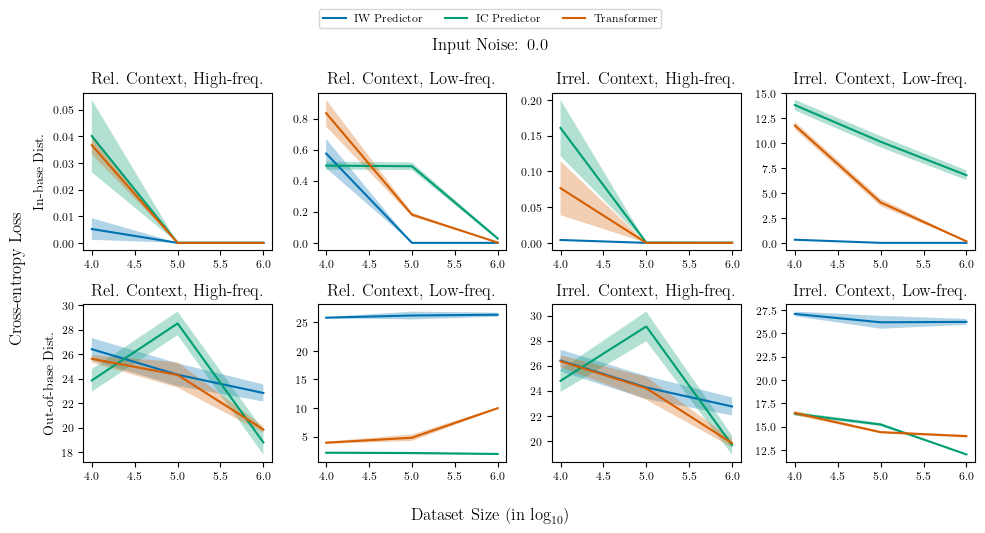

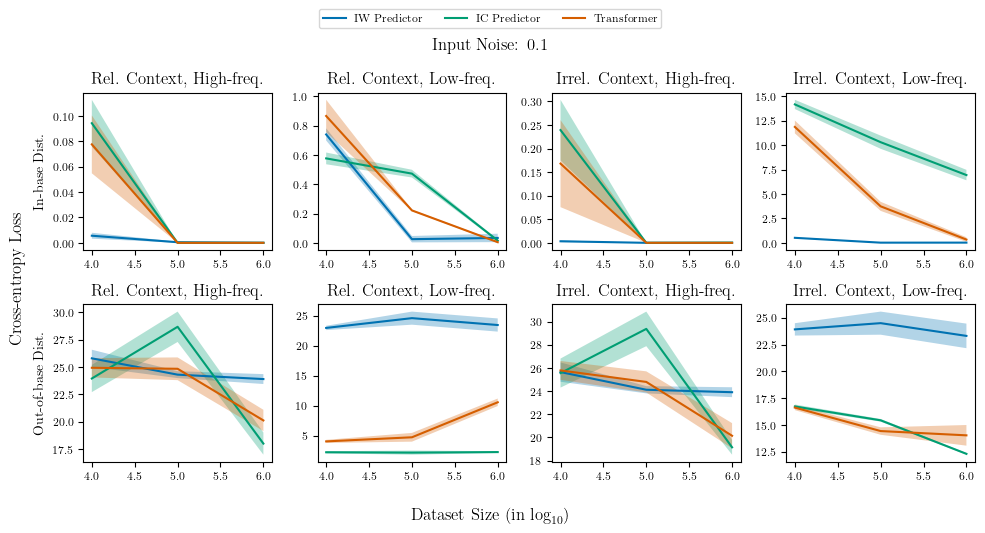

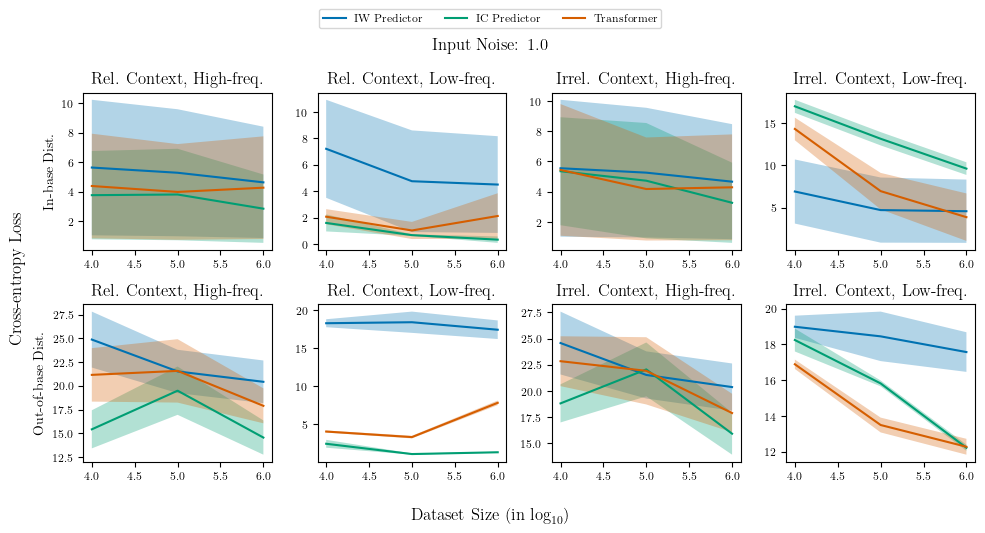

In [13]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            # ax.set_ylim(-1.0, 1.5)
            if eval_i == 0:
                ax.set_ylabel("In-base Dist." if row_i == 0 else "Out-of-base Dist.")

    fig.suptitle("Input Noise: {}".format(input_noise_std))
    fig.supylabel("Cross-entropy Loss")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

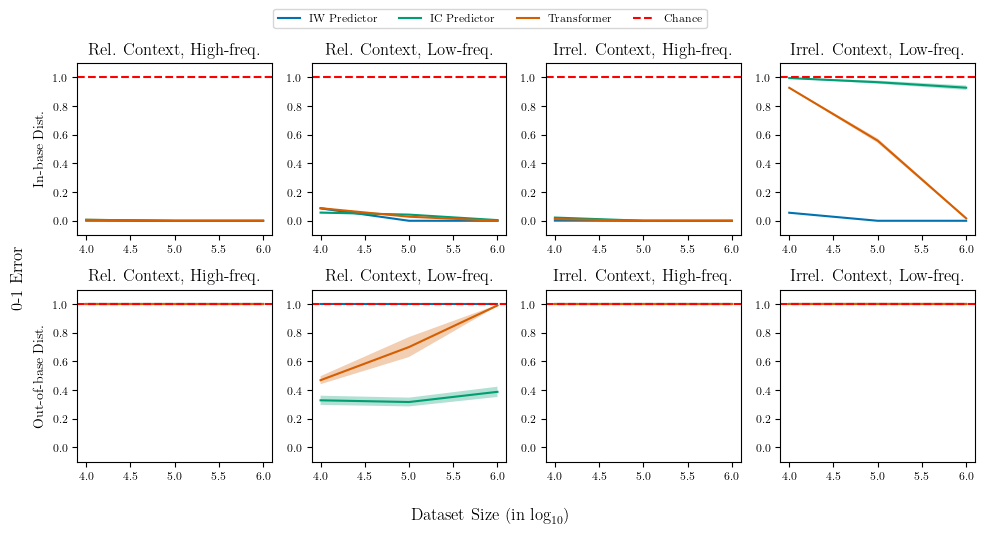

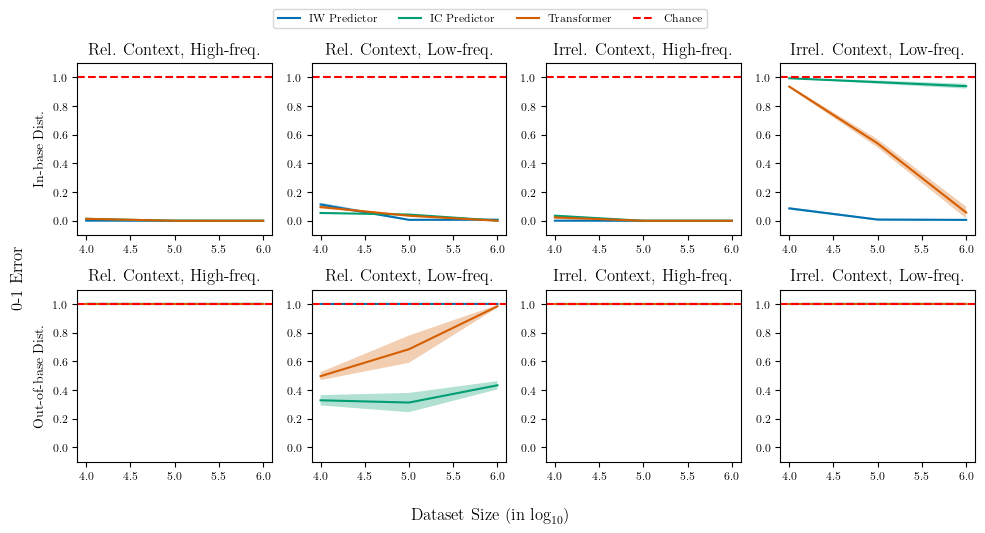

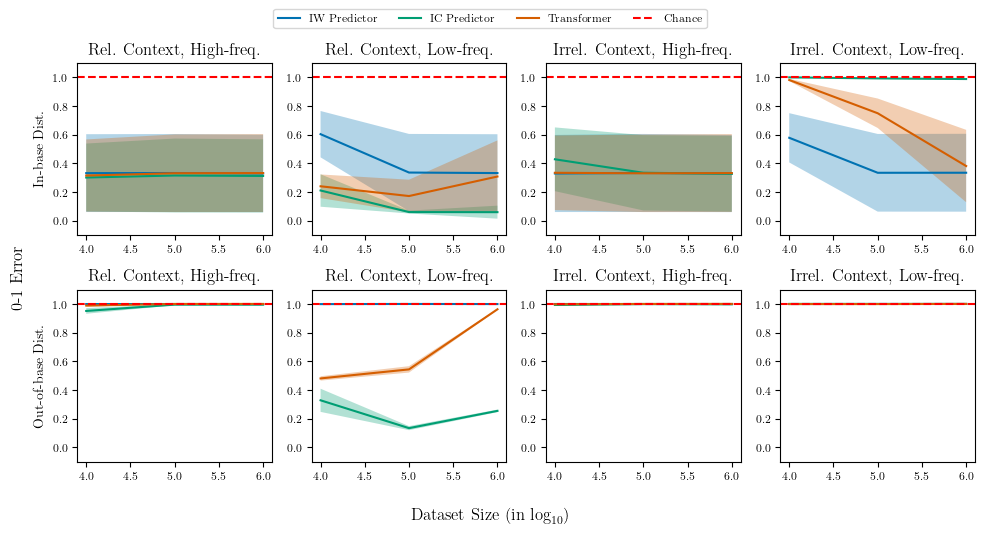

In [14]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]
for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for model_type in model_types:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = 1 - (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["input_noise_std"] == f"{input_noise_std}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["model_type"] == f"{model_type}")
                    ]["stats"].to_list()))
                    best_idx = best_idxes[(
                        model_type, p_relevant_context, input_noise_std, dataset_size
                    )]
                    sample = data[np.arange(num_seeds), best_idx]
                    curr_mean = np.mean(sample)
                    curr_std = np.std(sample)
                    
                    losses_mean.append(curr_mean)
                    losses_std.append(curr_std)

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(num_seeds)

                ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            ax.axhline(chance_error, label="Chance" if eval_i == 0 and row_i == 0 else "", c="red", linestyle="--")
            ax.set_ylim(-0.1, 1.1)

            if eval_i == 0:
                ax.set_ylabel("In-base Dist." if row_i == 0 else "Out-of-base Dist.")

    fig.supylabel("0-1 Error")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

In [15]:
stats["eval_name"].unique()

array(['eval-default-none-flip_label',
       'eval-default-high_prob-flip_label',
       'eval-default-low_prob-flip_label',
       'eval-relevant_context-none-flip_label',
       'eval-relevant_context-high_prob-flip_label',
       'eval-relevant_context-low_prob-flip_label',
       'eval-irrelevant_context-none-flip_label',
       'eval-irrelevant_context-high_prob-flip_label',
       'eval-irrelevant_context-low_prob-flip_label', 'eval-default-none',
       'eval-default-high_prob', 'eval-default-low_prob',
       'eval-relevant_context-none', 'eval-relevant_context-high_prob',
       'eval-relevant_context-low_prob', 'eval-irrelevant_context-none',
       'eval-irrelevant_context-high_prob',
       'eval-irrelevant_context-low_prob', 'pretraining'], dtype=object)

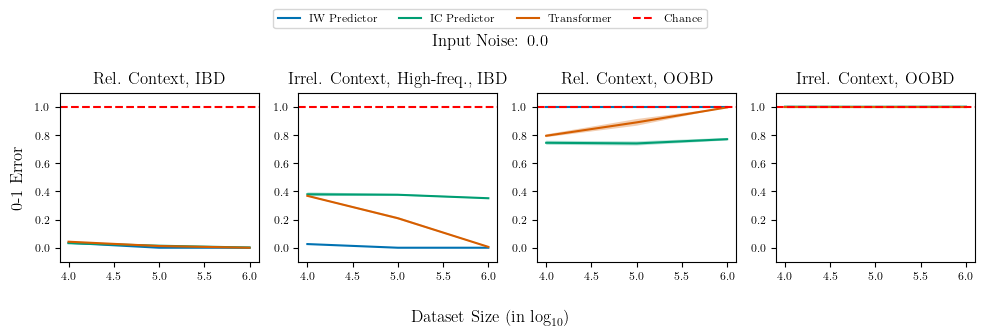

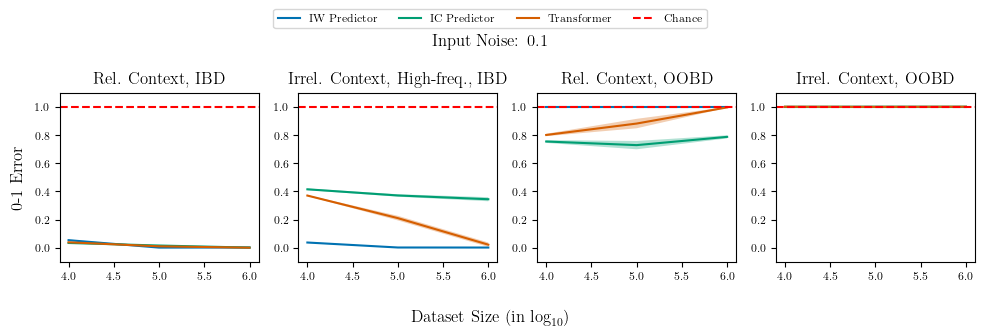

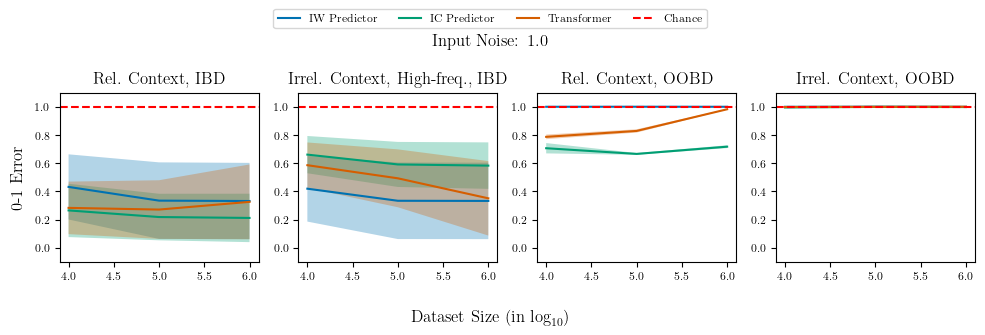

In [16]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
}

eval_names = [
    "eval-relevant_context-none",
    "eval-irrelevant_context-none",
    "eval-relevant_context-none-flip_label",
    "eval-irrelevant_context-none-flip_label",
]
for input_noise_std in input_noise_stds:
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[eval_i]
        for model_type in model_types:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 else "")
            ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        ax.axhline(chance_error, label="Chance" if eval_i == 0 else "", c="red", linestyle="--")
        ax.set_ylim(-0.1, 1.1)

    fig.suptitle("Input Noise: {}".format(input_noise_std))
    fig.supylabel("0-1 Error")
    fig.supxlabel("Dataset Size {}".format(dataset_unit))
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

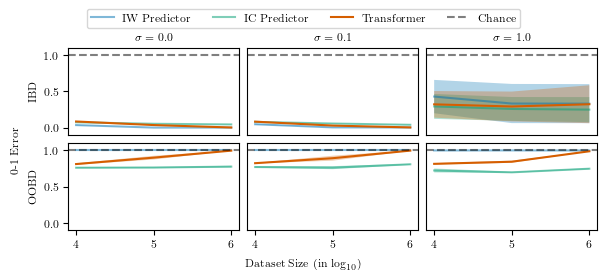

In [17]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-relevant_context-none": "Rel. Context, IBD",
    "eval-relevant_context-none-flip_label": "Rel. Context, OOBD",
    "eval-irrelevant_context-none": "Irrel. Context, High-freq., IBD",
    "eval-irrelevant_context-none-flip_label": "Irrel. Context, OOBD",
    "eval-default-none": "IBD",
    "eval-default-none-flip_label": "OOBD",
}

eval_names = [
    "eval-default-none",
    "eval-default-none-flip_label",
]

num_rows = 2
num_cols = len(input_noise_stds)
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=set_size(doc_width_pt, 0.95, (num_rows, num_cols), use_golden_ratio=True),
    layout="constrained",
)
for col_i, input_noise_std in enumerate(input_noise_stds):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[eval_i, col_i]
        # ax = axes[eval_i]
        for model_type in model_types:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = 1 - (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["input_noise_std"] == f"{input_noise_std}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["model_type"] == f"{model_type}")
                ]["stats"].to_list()))
                best_idx = best_idxes[(
                    model_type, p_relevant_context, input_noise_std, dataset_size
                )]
                sample = data[np.arange(num_seeds), best_idx]
                curr_mean = np.mean(sample)
                curr_std = np.std(sample)
                
                losses_mean.append(curr_mean)
                losses_std.append(curr_std)

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(num_seeds)

            ax.plot(dataset_scale(np.array(dataset_sizes)), losses_mean, label=map_label[model_type] if eval_i == 0 and col_i == 0 else "", alpha=1.0 if model_type == "transformer" else 0.5)
            ax.fill_between(dataset_scale(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.axhline(chance_error, label="Chance" if eval_i == 0 and col_i == 0 else "", c="black", linestyle="--", alpha=0.5)
        ax.set_ylim(-0.1, 1.1)
        loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name], fontsize="8")

        if col_i > 0:
            ax.set_yticks([])

        if eval_i == 0:
            ax.set_xticks([])
    
    axes[0, col_i].set_title(f"$\\sigma = {input_noise_std}$", fontsize="8")

# fig.suptitle("Input Noise")
fig.supylabel("0-1 Error", fontsize="8")
fig.supxlabel("Dataset Size {}".format(dataset_unit), fontsize="8")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
# fig.tight_layout()
plt.savefig("{}-noisy_inputs.pdf".format(variant_name), dpi=600, format="pdf", bbox_inches="tight")